# Assignment 3: Regression

## Import modules and data

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno 
import xgboost as xg

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib

In [61]:
pd.set_option('display.max_columns', None)

In [62]:
df = pd.read_csv("model.csv")

In [63]:
df['duration'].sort_values()

6794       31.133000
611        32.367000
7925       32.506668
1749       32.666000
1969       33.090000
            ...     
8657     1768.941700
4054     1768.941700
2723     1768.941700
11214    1768.941700
11665    2554.440000
Name: duration, Length: 12000, dtype: float64

## Inconsistent values

In [64]:
df['b_size'].value_counts()

0    12000
Name: b_size, dtype: int64

In [65]:
#By definition "b_size" should be "size - i_size - p_size"
df['b_size'] = df['size'] - df['p_size'] - df['i_size']

In [66]:
(df['size'] - df['p_size'] - df['i_size'] - df['b_size']).sum()

0

Much better

## Feature creation

In [67]:
#Width and height are not very useful, we think the total number of pixels might be more insightful
df['resolution'] = df['width'] * df['height']
df['o_resolution'] = df['o_width'] * df['o_height']

In [68]:
#Maybe we can keep the ratio
df['ratio'] = df['width'] / df['height']
df['o_ratio'] = df['o_width'] / df['o_height']

In [69]:
#Let's see if we have videos with different ratios (why are people stretching videos??)
(df['ratio'] - df['o_ratio']).value_counts()

-0.444444    5441
 0.000000    3492
 0.444444    1373
-0.555556    1357
-0.111111     243
 0.555556      94
dtype: int64

Lot of videos have been stretched

In [70]:
#Let's create some features which describe better the deltas between the video before and after being converted
df['diff_resolution'] = (df["width"]*df["height"])-(df["o_width"]*df["o_height"])

df["diff_framerate"] = df["framerate"]-df["o_framerate"]

df["diff_bitrate"] = df["bitrate"] - df["o_bitrate"]

df["diff_ratio"] = df['ratio'] - df['o_ratio']

In [71]:
df['codec_concat'] = df['codec'] + '-' + df['o_codec']

In [72]:
df['codec_concat'].value_counts()/len(df)*100

h264-h264      24.908333
h264-vp8       17.725000
vp8-h264       13.158333
vp8-vp8        10.191667
mpeg4-h264      7.641667
h264-mpeg4      6.833333
flv-h264        5.008333
mpeg4-vp8       4.108333
vp8-mpeg4       3.641667
flv-vp8         3.241667
mpeg4-mpeg4     1.583333
flv-mpeg4       1.350000
h264-flv        0.558333
vp8-flv         0.050000
Name: codec_concat, dtype: float64

We might keep only categories with at least 1% frequency

## Categorical exploratory analysis

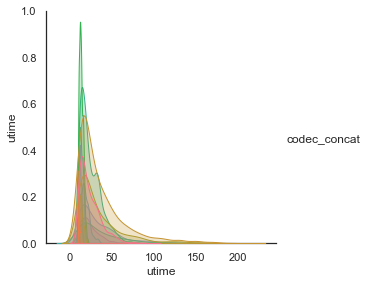

In [73]:
sns.pairplot(data=df[["codec_concat","utime"]], hue="codec_concat", height=4)

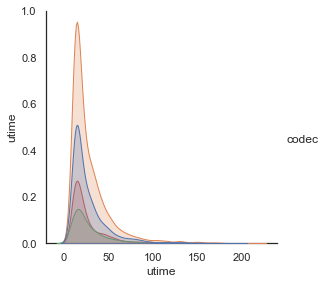

In [74]:
sns.pairplot(data=df[["codec","utime"]], hue="codec", height=4)

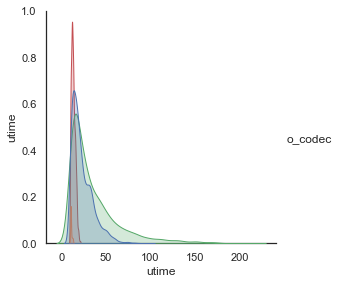

In [75]:
sns.pairplot(data=df[["o_codec","utime"]], hue="o_codec", height=4)

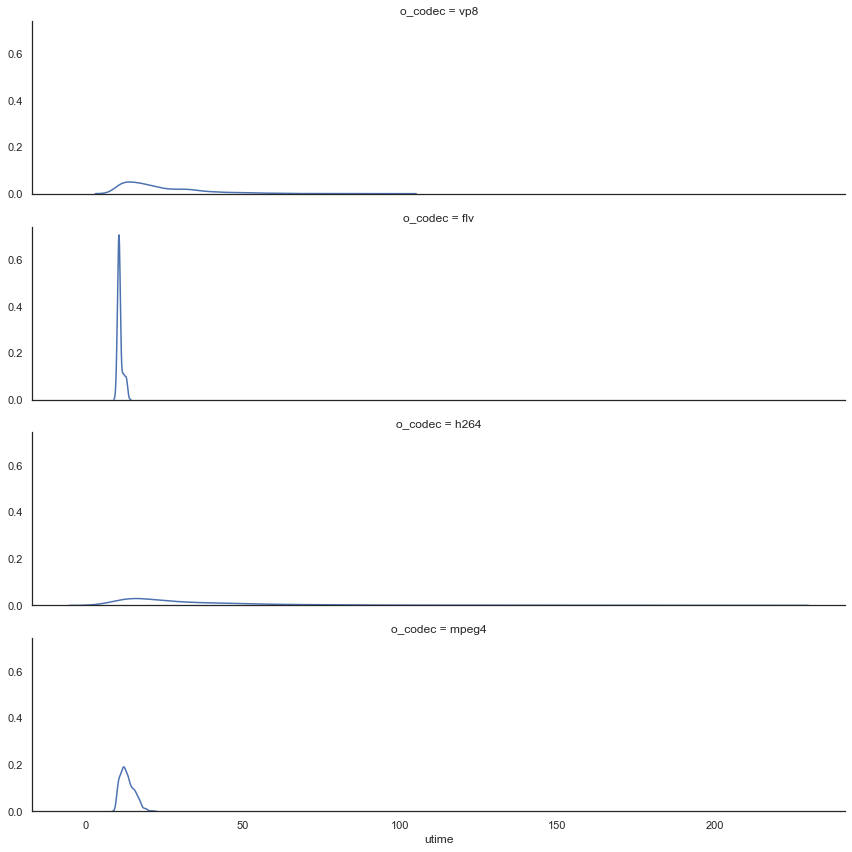

In [76]:
g = sns.FacetGrid(df, row="o_codec", 
                  height=3, aspect=4,)
g.map(sns.kdeplot, "utime")

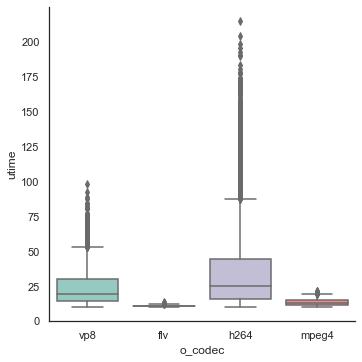

In [77]:
sns.catplot(data=df, x="o_codec", y="utime",kind="box", palette="Set3")

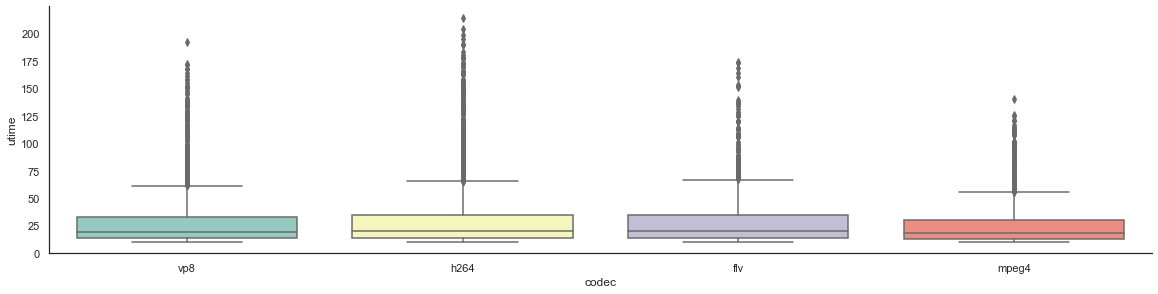

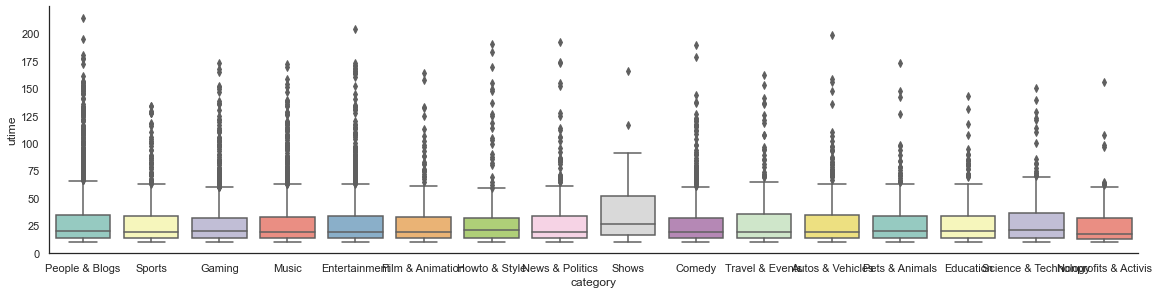

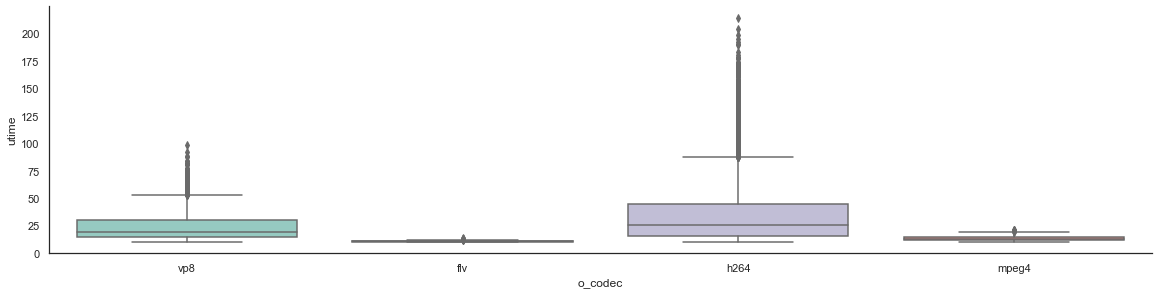

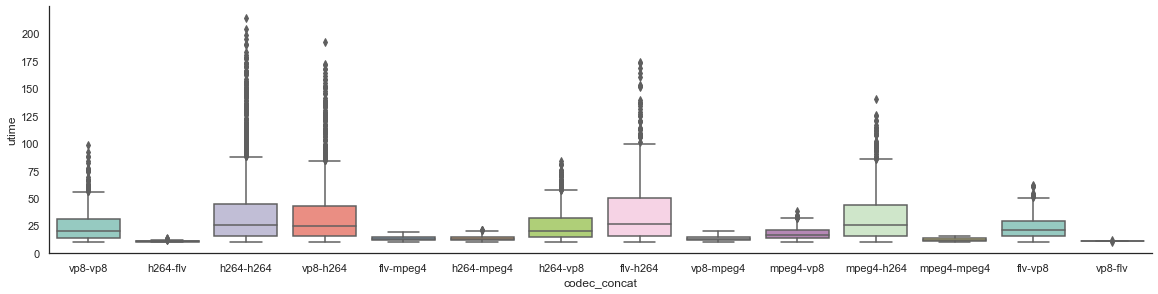

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for i in df.select_dtypes(include=['object']).columns:
    sns.catplot(data=df, x=i, y="utime",
            kind="box", palette="Set3",height=4, aspect=4);
plt.show()



## Categorical encoding

### First strategy for categorical values

In [79]:
cat_columns = ['codec', 'o_codec']
df_bicodec = pd.get_dummies(df, columns=cat_columns, prefix=cat_columns).drop(columns=['codec_concat'])

### Second strategy for categorical value

In [80]:
cat_columns = ['codec_concat']
df_unicodec = pd.get_dummies(df, columns=cat_columns,prefix=cat_columns).drop(columns=['codec', 'o_codec'])

In [81]:
df_unicodec.sample(5)

,id,duration,width,height,bitrate,category,framerate,i,p,b,frames,i_size,p_size,b_size,size,o_bitrate,o_framerate,o_width,o_height,umem,utime,resolution,o_resolution,ratio,o_ratio,diff_resolution,diff_framerate,diff_bitrate,diff_ratio,codec_concat_flv-h264,codec_concat_flv-mpeg4,codec_concat_flv-vp8,codec_concat_h264-flv,codec_concat_h264-h264,codec_concat_h264-mpeg4,codec_concat_h264-vp8,codec_concat_mpeg4-h264,codec_concat_mpeg4-mpeg4,codec_concat_mpeg4-vp8,codec_concat_vp8-flv,codec_concat_vp8-h264,codec_concat_vp8-mpeg4,codec_concat_vp8-vp8
804,805,143.03334,176,144,51082,Science & Technology,12.000000,31,1685,0,1716,56405,856907,0,913312,242000,29.97,640,480,219480,11.905,25344,307200,1.222222,1.333333,-281856,-17.970000,-190918,-0.111111,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2553,2554,69.93300,320,240,272898,Autos & Vehicles,15.000000,37,1013,0,1050,349781,2035796,0,2385577,5000000,12.00,1920,1080,219656,41.687,76800,2073600,1.333333,1.777778,-1996800,3.000000,-4727102,-0.444444,0,0,1,0,0,0,0,0,0,0,0,0,0,0
614,615,391.08000,640,480,230847,People & Blogs,25.000000,209,9569,0,9778,9023743,2261252,0,11284995,56000,25.00,1280,720,219480,14.777,307200,921600,1.333333,1.777778,-614400,0.000000,174847,-0.444444,0,0,0,0,0,0,1,0,0,0,0,0,0,0
10124,10125,304.92700,320,240,134334,People & Blogs,25.075659,82,7541,0,7623,833754,4286526,0,5120280,5000000,24.00,480,360,216820,17.033,76800,172800,1.333333,1.333333,-96000,1.075659,-4865666,0.000000,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2103,2104,189.95600,320,240,231296,People & Blogs,29.000000,97,5597,0,5694,580292,4911734,0,5492026,3000000,25.00,480,360,218664,14.421,76800,172800,1.333333,1.333333,-96000,4.000000,-2768704,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [82]:
df_bicodec.sample(5)

,id,duration,width,height,bitrate,category,framerate,i,p,b,frames,i_size,p_size,b_size,size,o_bitrate,o_framerate,o_width,o_height,umem,utime,resolution,o_resolution,ratio,o_ratio,diff_resolution,diff_framerate,diff_bitrate,diff_ratio,codec_flv,codec_h264,codec_mpeg4,codec_vp8,o_codec_flv,o_codec_h264,o_codec_mpeg4,o_codec_vp8
659,660,163.897000,320,240,267032,People & Blogs,29.0,87,4826,0,4913,824159,4646573,0,5470732,5000000,29.97,1920,1080,219656,18.189,76800,2073600,1.333333,1.777778,-1996800,-0.97,-4732968,-0.444444,1,0,0,0,0,0,1,0
7803,7804,49.178333,176,144,54338,Music,7.0,10,334,0,344,33046,300986,0,334032,3000000,12.00,1280,720,318252,20.309,25344,921600,1.222222,1.777778,-896256,-5.00,-2945662,-0.555556,0,0,1,0,0,1,0,0
7981,7982,106.765000,1280,720,849586,Film & Animation,25.0,66,2603,0,2669,4427240,6911026,0,11338266,820000,29.97,1280,720,219480,17.473,921600,921600,1.777778,1.777778,0,-4.97,29586,0.000000,0,1,0,0,0,0,0,1
5540,5541,52.680000,480,360,372001,Comedy,25.0,53,1265,0,1318,870136,1579497,0,2449633,242000,29.97,1920,1080,139940,16.553,172800,2073600,1.333333,1.777778,-1900800,-4.97,130001,-0.444444,0,1,0,0,0,0,1,0
6473,6474,906.598300,176,144,56108,Comedy,12.0,187,10692,0,10879,597549,5760936,0,6358485,5000000,25.00,1920,1080,165668,25.862,25344,2073600,1.222222,1.777778,-2048256,-13.00,-4943892,-0.555556,0,0,1,0,0,0,0,1


## Numerical Exploratory analysys

<AxesSubplot:>

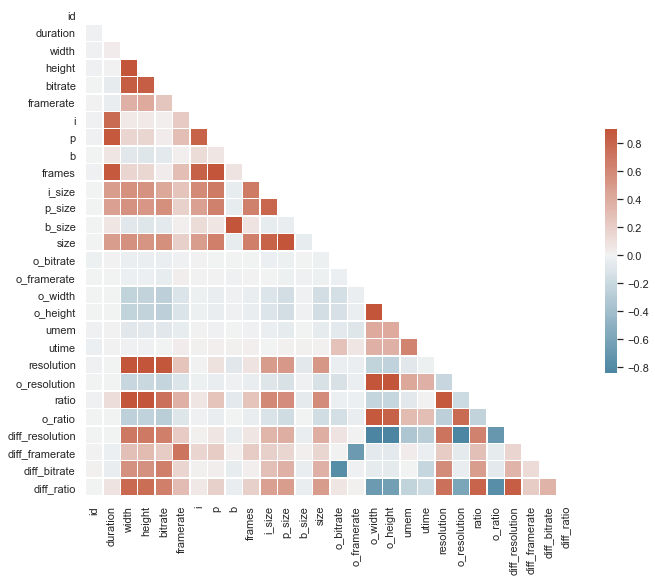

In [83]:
sns.set_theme(style="white")
corr = df_unicodec.select_dtypes(include=['float64','int64']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Of course the derived features have a high correlation with the primitive ones

In [84]:
keep_bicoded = ['diff_resolution', 'diff_framerate','diff_bitrate','diff_ratio', 
          'umem',
          "duration","size",'frames',
          'codec_vp8','codec_h264', 'codec_mpeg4', 
          'o_codec_vp8','o_codec_h264', 'o_codec_mpeg4', 
          'utime']

In [85]:
keep_unicoded = ['diff_resolution', 'diff_framerate','diff_bitrate','diff_ratio', 
        'umem',
        'duration','size','frames',
        'codec_concat_flv-h264', 'codec_concat_vp8-vp8',
        'codec_concat_flv-mpeg4', 'codec_concat_flv-vp8',
        'codec_concat_h264-h264','codec_concat_mpeg4-vp8',
        'codec_concat_h264-mpeg4', 'codec_concat_h264-vp8',
        'codec_concat_mpeg4-h264', 'codec_concat_mpeg4-mpeg4',
        'codec_concat_vp8-h264', 'codec_concat_vp8-mpeg4',
        'utime']

In [86]:
new_df = df_unicodec[keep_unicoded]
#new_df = df_bicodec[keep_bicoded]

<AxesSubplot:>

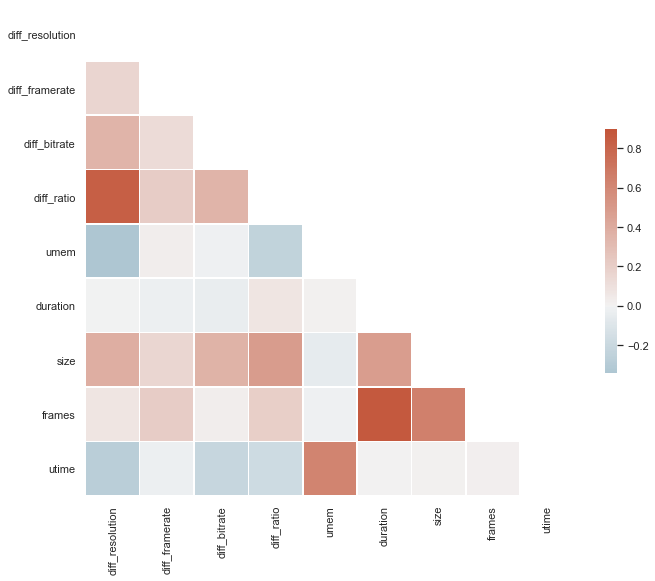

In [87]:
sns.set_theme(style="white")
corr = new_df.select_dtypes(include=['float64','int64']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

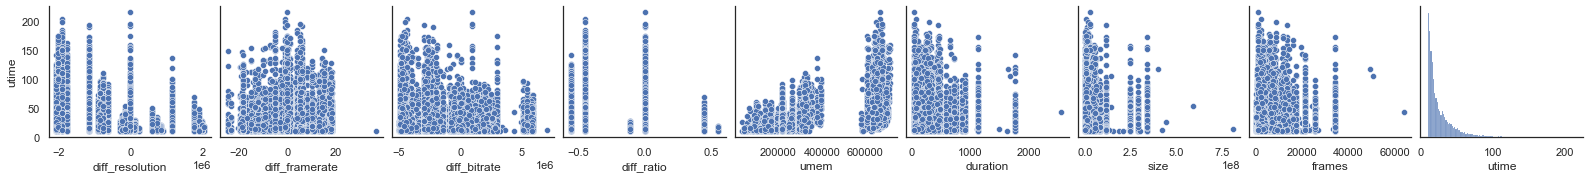

In [88]:
# visualize the relationship between the features and the response using scatterplots
import seaborn as sns
sns.pairplot(new_df.select_dtypes(include=['float64','int64']), x_vars=new_df.select_dtypes(include=['float64','int64']).columns, y_vars='utime')

In [89]:
new_df.to_csv("model_post_eda_bicodec.csv",index=False)

In [90]:
new_df

,diff_resolution,diff_framerate,diff_bitrate,diff_ratio,umem,duration,size,frames,codec_concat_flv-h264,codec_concat_vp8-vp8,codec_concat_flv-mpeg4,codec_concat_flv-vp8,codec_concat_h264-h264,codec_concat_mpeg4-vp8,codec_concat_h264-mpeg4,codec_concat_h264-vp8,codec_concat_mpeg4-h264,codec_concat_mpeg4-mpeg4,codec_concat_vp8-h264,codec_concat_vp8-mpeg4,utime
0,-844800,-4.937442,-13097,-0.444444,218932,645.840000,7742262,16146,0,1,0,0,0,0,0,0,0,0,0,0,15.929
1,0,-6.970000,5179648,0.000000,218932,326.588320,244926878,7830,0,0,0,0,0,0,0,0,0,0,0,0,10.417
2,-1996800,1.000000,-77983,-0.444444,645544,473.000000,9697521,11826,0,0,0,0,1,0,0,0,0,0,0,0,45.327
3,-1152000,15.002232,-947574,0.000000,655172,448.575000,115083398,13441,0,0,0,0,0,0,0,0,0,0,1,0,102.842
4,-1996800,0.000000,-569724,-0.444444,216820,255.280000,7986338,6382,0,0,1,0,0,0,0,0,0,0,0,0,14.937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,-896256,-22.970000,-4945662,-0.555556,324540,49.178333,334032,344,0,0,0,0,0,0,0,0,1,0,0,0,34.462
11996,-1900800,14.000000,-129959,-0.444444,654236,80.536000,6946645,2417,0,0,0,0,1,0,0,0,0,0,0,0,68.984
11997,0,-16.487333,-25925,0.000000,327492,750.433000,74487589,10112,0,0,0,0,0,0,0,0,0,0,1,0,33.402
11998,-844800,0.000000,-77983,-0.444444,318500,473.000000,9697521,11826,0,0,0,0,1,0,0,0,0,0,0,0,30.266


## Split train test

In [91]:
y = new_df['utime']
X = new_df.drop("utime",axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [92]:
train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)

## Model

### Grid search

In [93]:
# Instantiation
'''

xgb_r = xg.XGBRegressor()

parameters = {'nthread':[-1], #when use hyperthread, xgboost may become slower
              'objective' : ['reg:squarederror'],
              'learning_rate': [0.05,0.1], #so called `eta` value
              'max_depth': [10,20,50],
              'min_child_weight': [2,5,10,15],
              'colsample_bytree' : [0.3,0.6,0.9],
              'n_estimators': [1000,1500,2000], #number of trees, change it to 1000 for better results
              'seed': [1337],
              'eval_metric': ["mae"]}
'''

'\n\nxgb_r = xg.XGBRegressor()\n\nparameters = {\'nthread\':[-1], #when use hyperthread, xgboost may become slower\n              \'objective\' : [\'reg:squarederror\'],\n              \'learning_rate\': [0.05,0.1], #so called `eta` value\n              \'max_depth\': [10,20,50],\n              \'min_child_weight\': [2,5,10,15],\n              \'colsample_bytree\' : [0.3,0.6,0.9],\n              \'n_estimators\': [1000,1500,2000], #number of trees, change it to 1000 for better results\n              \'seed\': [1337],\n              \'eval_metric\': ["mae"]}\n'

In [94]:
#gs = GridSearchCV(xgb_r, parameters, cv=5, scoring = 'neg_mean_absolute_error', verbose=0, n_jobs=5, refit=True)
#gs.fit(train_X,train_y)

In [95]:
#gs.best_params_

In [96]:
#gs.best_score_

In [97]:
#xgb_r = gs

## Manual model fit

In [98]:
# manual
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7, learning_rate = 0.05, 
                max_depth = 10, alpha = 0, n_estimators = 4000, gamma = 0, min_child_weight = 20, subsample = 0.9)

In [99]:
# Fitting the model
xgb_r.fit(train_X, train_y)
  
# Predict the model
#pred = xgb_r.predict(X)

XGBRegressor(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=20, missing=nan, monotone_constraints='()',
             n_estimators=4000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Model evaluation

In [100]:
from sklearn import metrics

print("Score Train:")
print("MAE train: ", metrics.mean_absolute_error(train_y, xgb_r.predict(train_X)))
print("MSE train: ",metrics.mean_squared_error(train_y, xgb_r.predict(train_X)))
print("RMSE train: ",np.sqrt(metrics.mean_squared_error(train_y, xgb_r.predict(train_X))))
print("r2: ",np.sqrt(metrics.r2_score(train_y, xgb_r.predict(train_X))))
print("\n")
print("Score test:")
print("MAE test: ", metrics.mean_absolute_error(test_y, xgb_r.predict(test_X))) 
print("MSE test: ",metrics.mean_squared_error(test_y, xgb_r.predict(test_X)))
print("RMSE test: ",np.sqrt(metrics.mean_squared_error(test_y, xgb_r.predict(test_X))))
print("r2: ",np.sqrt(metrics.r2_score(test_y, xgb_r.predict(test_X))))

Score Train:
MAE train:  0.2781701180040268
MSE train:  0.1489992433358025
RMSE train:  0.3860042011893167
r2:  0.9998639595632789


Score test:
MAE test:  1.5332642391649882
MSE test:  8.26190330519081
RMSE test:  2.8743526758543063
r2:  0.9924913622702339


In [101]:
error_train=xgb_r.predict(train_X)-train_y
error_test=xgb_r.predict(test_X)-test_y

error_train.describe()
error_test.describe()

count    3600.000000
mean       -0.036883
std         2.874515
min       -31.608022
25%        -0.782927
50%         0.032415
75%         0.810197
max        28.490797
Name: utime, dtype: float64

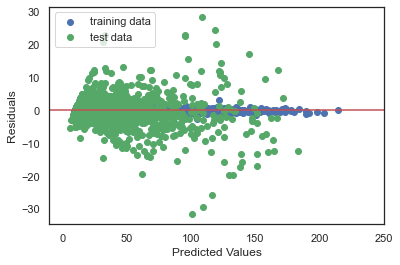

In [105]:
plt.scatter(xgb_r.predict(train_X),error_train, c="b", label="training data")
plt.scatter(xgb_r.predict(test_X),error_test, c="g", label="test data")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=-10, xmax=250, color="r")
plt.xlim([-10,250])
plt.show()

In [103]:
error_train = np.array(error_train).reshape(-1,1)
scaled_error_train= StandardScaler(copy=False).fit(error_train).transform(error_train).flatten()

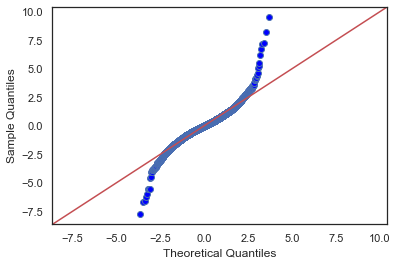

In [104]:
import statsmodels.api as sm
from matplotlib import pyplot as plt

fig = sm.qqplot(scaled_error_train,line='45')
plt.show()

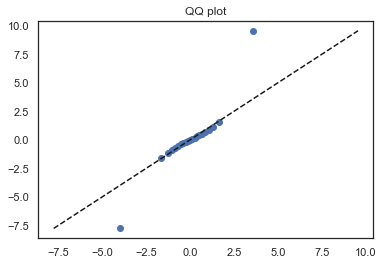

In [105]:
import scipy

# We test a uniform distribution
dist = getattr(scipy.stats, 'norm')
    
# We generate a sample of size  len(mr_scaled) of data distributed according to distribution dist
# The function rvs generates a sample with distribution dist with mean loc and std scale
test_dist = dist.rvs(0,1,size = len(scaled_error_train))
test_dist.sort()

# We create the percentiles for both distributions
percs = np.linspace(0,100,21)
q_b = np.percentile(scaled_error_train, percs)
q_a = np.percentile(test_dist, percs)

# and generate the QQ-plot 
plt.plot(q_a,q_b, ls="", marker="o")
plt.title("QQ plot")
x = np.linspace(np.min((q_a.min(),q_b.min())), np.max((q_a.max(),q_b.max())))
plt.plot(x,x, color="k", ls="--")
plt.show()

## Model interpretation

In [47]:
%matplotlib inline
df_X_train=pd.DataFrame(train_X,columns=new_df.drop('utime',axis=1).columns)

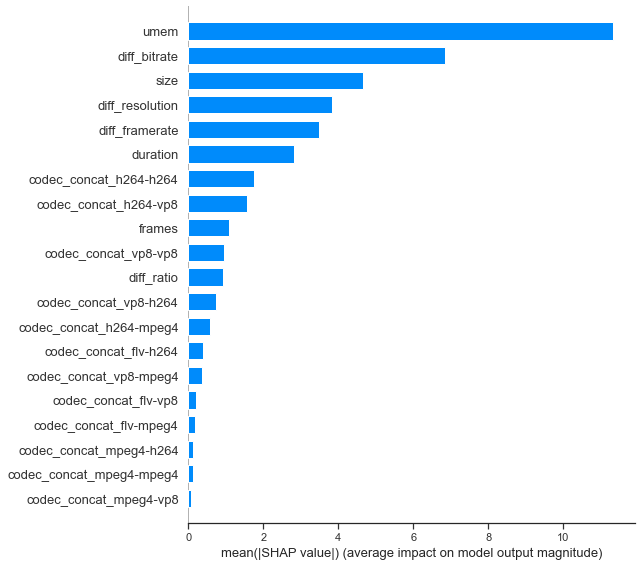

In [48]:
import shap  

explainer_rf = shap.TreeExplainer(xgb_r)
shap_values = explainer_rf.shap_values(df_X_train)

shap.summary_plot(shap_values, df_X_train, plot_type="bar")



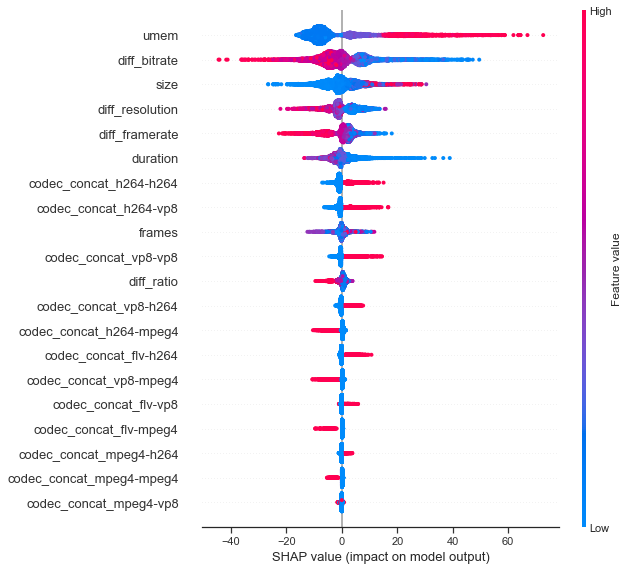

In [49]:
shap.summary_plot(shap_values, df_X_train)

### REfit

In [106]:
y = new_df['utime']
X = new_df.drop("utime",axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [107]:
# manual
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7, learning_rate = 0.05, 
                max_depth = 10, alpha = 0, n_estimators = 4000, gamma = 0, min_child_weight = 20, subsample = 0.9)

In [108]:
# Fitting the model
xgb_r.fit(X, y)
  
# Predict the model
#pred = xgb_r.predict(X)

XGBRegressor(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=20, missing=nan, monotone_constraints='()',
             n_estimators=4000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Predictions

In [109]:
pred = pd.read_csv("predictions.csv")

In [110]:
#Width and height are not very useful, we think the total number of pixels might be more insightful
pred['resolution'] = pred['width'] * pred['height']
pred['o_resolution'] = pred['o_width'] * pred['o_height']

In [111]:
#Maybe we can keep the ratio
pred['ratio'] = pred['width'] / pred['height']
pred['o_ratio'] = pred['o_width'] / pred['o_height']

In [112]:
#Let's see if we have videos with different ratios (why are people stretching videos??)
(pred['ratio'] - pred['o_ratio']).value_counts()

-0.444444    2646
 0.000000    1779
-0.555556     641
 0.444444     624
-0.111111     110
 0.555556      36
dtype: int64

Lot of videos have been stretched

In [113]:
#Let's create some features which describe better the deltas between the video before and after being converted
pred['diff_resolution'] = (pred["width"]*pred["height"])-(pred["o_width"]*pred["o_height"])

pred["diff_framerate"] = pred["framerate"]-pred["o_framerate"]

pred["diff_bitrate"] = pred["bitrate"] - pred["o_bitrate"]

pred["diff_ratio"] = pred['ratio'] - pred['o_ratio']

In [114]:
pred['codec_concat'] = pred['codec'] + '-' + pred['o_codec']

In [115]:
pred.sample(5)

,id,duration,codec,width,height,bitrate,category,framerate,i,p,b,frames,i_size,p_size,b_size,size,o_codec,o_bitrate,o_framerate,o_width,o_height,umem,resolution,o_resolution,ratio,o_ratio,diff_resolution,diff_framerate,diff_bitrate,diff_ratio,codec_concat
2339,14340,37.011665,h264,1280,720,2759449,Gaming,29.000000,21,1088,0,1109,1899633,10866846,0,12766479,h264,5000000,25.00,320,240,219480,921600,76800,1.777778,1.333333,844800,4.000000,-2240551,0.444444,h264-h264
4320,16321,458.625000,h264,640,480,517364,Entertainment,29.000000,245,13501,0,13746,5308581,24350943,0,29659524,vp8,56000,24.00,1280,720,216820,307200,921600,1.333333,1.777778,-614400,5.000000,461364,-0.444444,h264-vp8
1335,13336,216.550000,h264,320,240,291150,Howto & Style,29.000000,112,6379,0,6491,1789334,6091735,0,7881069,vp8,3000000,24.00,1920,1080,199292,76800,2073600,1.333333,1.777778,-1996800,5.000000,-2708850,-0.444444,h264-vp8
641,12642,426.945000,h264,1280,720,1064703,People & Blogs,29.000000,228,12567,0,12795,11297544,45523691,0,56821235,h264,5000000,29.97,480,360,219480,921600,172800,1.777778,1.333333,748800,-0.970000,-3935297,0.444444,h264-h264
3416,15417,1140.349000,vp8,1280,720,2394626,Music,30.007017,328,33880,0,34208,20478926,320859863,0,341338789,vp8,3000000,15.00,480,360,219480,921600,172800,1.777778,1.333333,748800,15.007017,-605374,0.444444,vp8-vp8


In [116]:
cat_columns = ['codec_concat']
pred_unicodec = pd.get_dummies(pred, columns=cat_columns,prefix=cat_columns).drop(columns=['codec', 'o_codec'])

In [119]:
keep_unicoded.remove('utime')

In [120]:
#keep_unicoded
pred_df = pred_unicodec[keep_unicoded]
#new_df = df_bicodec[keep_bicoded]

In [121]:
pred_df

,diff_resolution,diff_framerate,diff_bitrate,diff_ratio,umem,duration,size,frames,codec_concat_flv-h264,codec_concat_vp8-vp8,codec_concat_flv-mpeg4,codec_concat_flv-vp8,codec_concat_h264-h264,codec_concat_mpeg4-vp8,codec_concat_h264-mpeg4,codec_concat_h264-vp8,codec_concat_mpeg4-h264,codec_concat_mpeg4-mpeg4,codec_concat_vp8-h264,codec_concat_vp8-mpeg4
0,-748800,-0.970000,-2309959,-0.444444,219480,80.536,6946645,2417,0,0,0,0,0,0,1,0,0,0,0,0
1,134400,-0.970000,-4482636,0.000000,216820,458.625,29659524,13746,0,0,0,0,1,0,0,0,0,0,0,0
2,-844800,-9.294248,-472320,-0.444444,248092,452.689,3773200,2579,0,1,0,0,0,0,0,0,0,0,0,0
3,-1766400,-4.948260,-2970904,-0.444444,221152,368.320,1339625,9208,0,0,0,0,0,0,0,0,0,0,0,1
4,1900800,15.000000,992818,0.444444,216020,39.055,29256190,1170,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5831,-896256,-17.970000,-52584,-0.555556,309436,311.100,2193902,3733,0,0,0,0,0,0,0,0,1,0,0,0
5832,0,5.000000,244703,0.000000,335656,426.945,56821235,12795,0,0,0,0,1,0,0,0,0,0,0,0
5833,1900800,6.000000,5453818,0.444444,216020,39.055,29256190,1170,0,0,0,0,1,0,0,0,0,0,0,0
5834,1766400,6.000000,5883818,0.444444,216020,39.055,29256190,1170,0,0,0,0,1,0,0,0,0,0,0,0


In [122]:
scaler = StandardScaler()
X = scaler.fit_transform(pred_df)

In [123]:
preds = xgb_r.predict(X)

In [124]:
preds

array([12.807499 , 15.8557625, 14.37597  , ..., 20.163857 , 18.477943 ,
       14.98416  ], dtype=float32)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

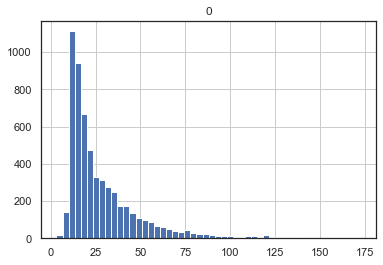

In [127]:
pd.DataFrame(preds).hist(bins=50)

In [129]:
pd.DataFrame(preds).to_csv("predictions_target.csv")